In [12]:
from ai_models_fourcastnetv2 import model as sfno
import h5py
import os
import cfgrib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import numpy as np
import xarray as xr

In [13]:
os.chdir('/home/jovyan/fourcastnetv2')

### Generate FourCastNetv2 prediction

Create a prediction using ECMWF ```ai-models``` plugin. Follow the README.md in the repository https://github.com/ikhadir/FCN4AWS. Make sure you are working in the same directory where the output is located.

Here are initial condition dates for a few Hurricanes you may wish to track. 

Hurricane Erin(2025): ```ai-models --input cds --date 20250816 --time 0000 fourcastnetv2-small```

Hurricane Harvey(2017): ```ai-models --input cds --date 20170824 --time 0000 fourcastnetv2-small```

Hurricane Katrina(2005): ```ai-models --input cds --date 20170825 --time 0000 fourcastnetv2-small```

Hurricane Patricia(2015): ```ai-models --input cds --date 20151020 --time 0000 fourcastnetv2-small```

Hurricanes Jose, Maria, and Lee(2017): ```ai-models --input cds --date 20170916 --time 0000 fourcastnetv2-small```

In [334]:
# Path to your GRIB file, typically a fourcastnetv2 prediction
grib_file = "fourcastnetv2-small.grib"

# Load the GRIB file using xarray
ds = xr.open_dataset(grib_file, engine='cfgrib')

# Display the dataset structure
print(ds)

# Check the shape of a specific variable
for var in ds.data_vars:
    print(f"Shape of '{var}': {ds[var].shape}")



Ignoring index file 'fourcastnetv2-small.grib.5b7b6.idx' older than GRIB file
skipping variable: paramId==228246 shortName='u100'
Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/jovyan/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=10.0) new_value=Variable(dimensions=(), data=100.0)
skipping variable: paramId==228247 shortName='v100'
Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/jovyan/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildErro

<xarray.Dataset> Size: 12GB
Dimensions:            (step: 41, latitude: 721, longitude: 1440,
                        isobaricInhPa: 13)
Coordinates:
    time               datetime64[ns] 8B ...
  * step               (step) timedelta64[ns] 328B 0 days 00:00:00 ... 10 day...
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
    valid_time         (step) datetime64[ns] 328B ...
    surface            float64 8B ...
    meanSea            float64 8B ...
    entireAtmosphere   float64 8B ...
  * isobaricInhPa      (isobaricInhPa) float64 104B 1e+03 925.0 ... 100.0 50.0
Data variables:
    u10                (step, latitude, longitude) float32 170MB ...
    v10                (step, latitude, longitude) float32 170MB ...
    sp                 (step, latitude, longitude) float32 170MB ...
    msl                (step, latitude, longitude) float32 1

/home/jovyan/.local/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [335]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

variable_info = {
    'u10': {'name': '10m Wind Speed', 'unit': 'm/s'},
    'v10': {'name': '10m Wind Speed', 'unit': 'm/s'},
    'msl': {'name': 'Mean Sea Level Pressure', 'unit': 'hPa'},
    'sp': {'name': 'Surface Pressure', 'unit': 'hPa'},
    't': {'name': 'Temperature', 'unit': 'K'}  # Adjust unit if needed (e.g., °C)
}

def robinson_predictions_plot(predictions, variable, t, huh=False):
    dat = predictions[variable].values[t]
    if huh:
        dat = predictions[variable].values[t][0]
    print(dat.shape)

    if variable == 'sp' or variable == 'msl':
        dat = predictions[variable].values[t]/100
    
    # Create subplots with the Robinson projection centered on the Pacific (central_longitude=180)
    central_longitude = 180
    projection = ccrs.Robinson(central_longitude=central_longitude)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), subplot_kw={'projection': projection})
    
    # Define the extent of the map (in degrees)
    extent = (-180, 180, -90, 90)
   # extent = [-82, -65, 15, 50]
    
    # Define the color limits
    vmin, vmax = -2, 1
    
    
    # Plot the prediction data
    ax.set_global()
    im1 = ax.imshow(np.roll(dat, shift=dat.shape[-1]//2, axis=-1), 
                       transform=ccrs.PlateCarree(central_longitude=0), 
                       cmap="jet", extent=extent, origin='upper')#, vmin=vmin, vmax=vmax)
    ax.coastlines()
    ax.set_title(f"FourCastNetv2 {t * 6} Hour Prediction of {variable} from Z:00:00", fontsize=16)
    
    var_name = variable_info.get(variable, {}).get('name', variable)
    var_unit = variable_info.get(variable, {}).get('unit', '')

    # Add colorbar with dynamic label
    cbar = fig.colorbar(im1, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
    cbar.set_label(f"{var_name} ({var_unit})", fontsize=12)
    
    for i in np.arange(2):
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False

    #plt.savefig(f'FourCastNetv2_prediction_{variable}_Dec_25_2024_{t * 6}_hours_from_initialization.png')
    fig.tight_layout()
    plt.show()

(721, 1440)


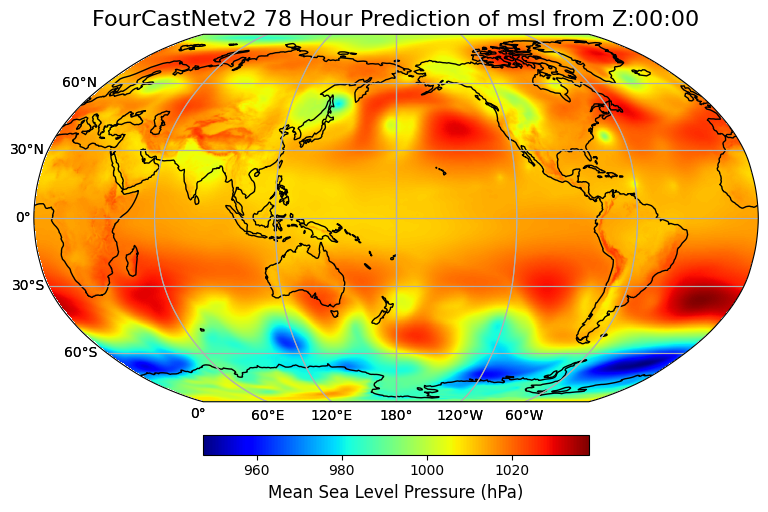

In [336]:
robinson_predictions_plot(ds, 'msl', 13)

(721, 1440)


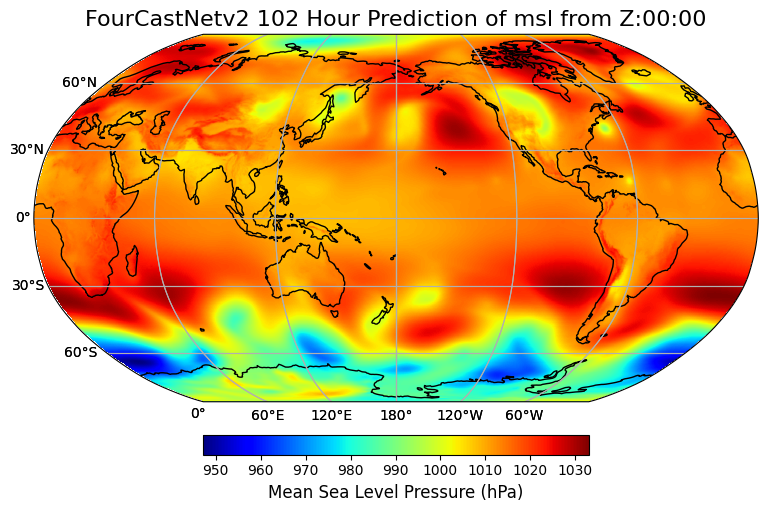

In [337]:
robinson_predictions_plot(ds, 'msl', 17)

Find the latitutde and longitute points for the event and name it ```extent```. Depending on the pressure level during the event you will want to adjust the ```vmax``` and ```vmin``` so the color map is scaled appropriately in the gif. If you do not want to use the gif or you don't mind a dynamic color bar then just remove those variables. Search online for the lowest pressure level for the weather event to determine an adequate minimum.

In [338]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

variable_info = {
    'u10': {'name': '10m Wind Speed', 'unit': 'm/s'},
    'v10': {'name': '10m Wind Speed', 'unit': 'm/s'},
    'msl': {'name': 'Mean Sea Level Pressure', 'unit': 'hPa'},
    'sp': {'name': 'Surface Pressure', 'unit': 'hPa'},
    't': {'name': 'Temperature', 'unit': 'K'}  # Adjust unit if needed
}

def hurricane_prediction_plot(predictions, variable, t, huh=False):
    # Get prediction data
    dat = predictions[variable].values[t]
    if huh:
        dat = predictions[variable].values[t][0]
    print(f"Data shape: {dat.shape}")

    # Convert pressure from Pa to hPa if needed
    if variable in ['sp', 'msl']:
        dat = dat / 100

    # Define map projection for regional plot
    projection = ccrs.PlateCarree()

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})

    # Set extent to zoom in on desired region
    #KATRINA 2005
    #extent = [-98, -70, 21, 44]  # [lon_min, lon_max, lat_min, lat_max]
    #ERIN 2025
    #extent = [-85, -60, 17, 41]
    #HARVEY 2017
    extent = [-105,-70,17,40]
    #PATRICIA 2015
    extent = [-120,-95,10,30]
    #MARIA 2017
    extent = [-85,-30,10,45]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add geographic features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5)

    # Plot the variable
    im = ax.imshow(dat, extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(),
                   cmap="jet", origin='upper')#,vmin=992,vmax=1020)

    # Title and colorbar
    import numpy as np
    import pandas as pd
    
    # Grab times from the dataset
    ic_dt = pd.to_datetime(ds.time.values)                      # scalar IC time (UTC)
    lead_hours = int(ds.step.values[t] / np.timedelta64(1, 'h'))  # lead in hours for frame t
    valid_dt = pd.to_datetime(ds.valid_time.values[t])          # valid time for frame t (UTC)
    
    # Nice strings
    ic_str = ic_dt.strftime("%Y-%m-%d %H:%M UTC")
    valid_str = valid_dt.strftime("%Y-%m-%d %H:%M UTC")
    
    ax.set_title(
        f"FourCastNetv2 {lead_hours}hr ({valid_str}) Prediction of {variable} "
        f"from IC: {ic_str}",
        fontsize=12
    )
    var_name = variable_info.get(variable, {}).get('name', variable)
    var_unit = variable_info.get(variable, {}).get('unit', '')
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
    cbar.set_label(f"{var_name} ({var_unit})", fontsize=12)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.tight_layout()
    plt.show()


Data shape: (721, 1440)


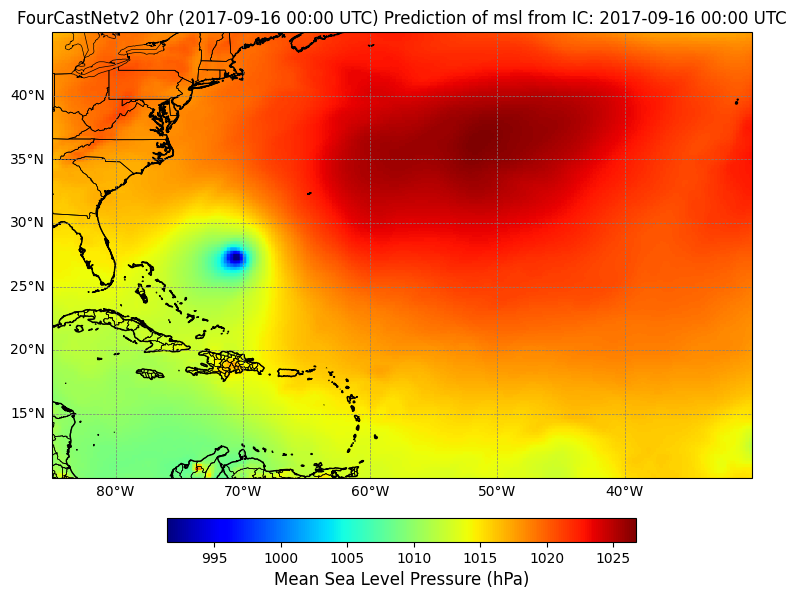

Data shape: (721, 1440)


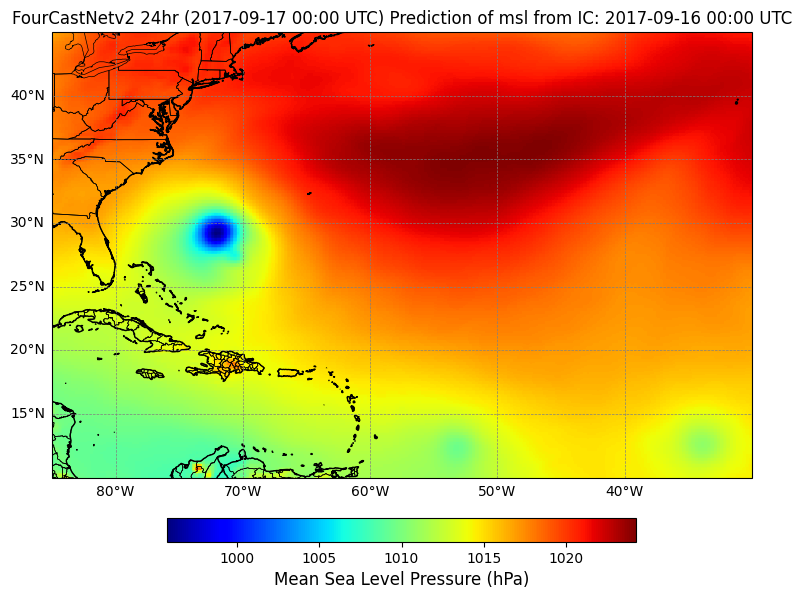

Data shape: (721, 1440)


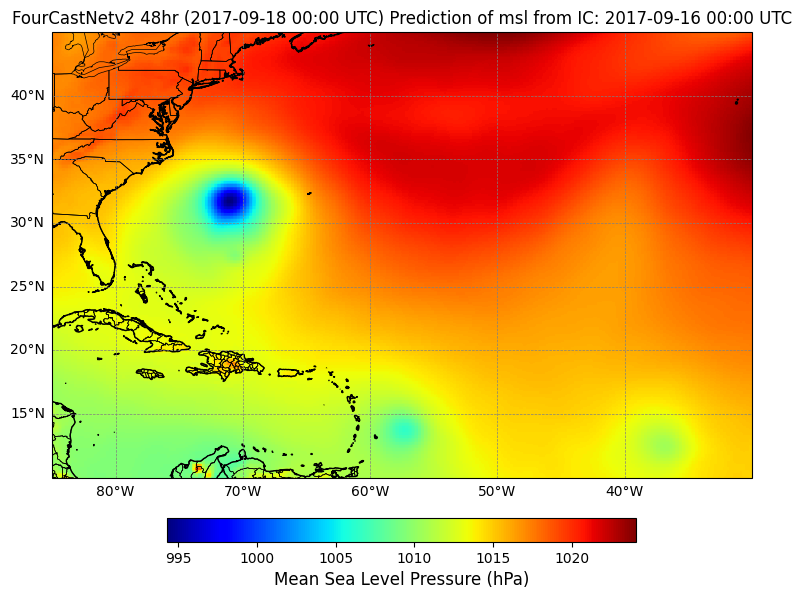

Data shape: (721, 1440)


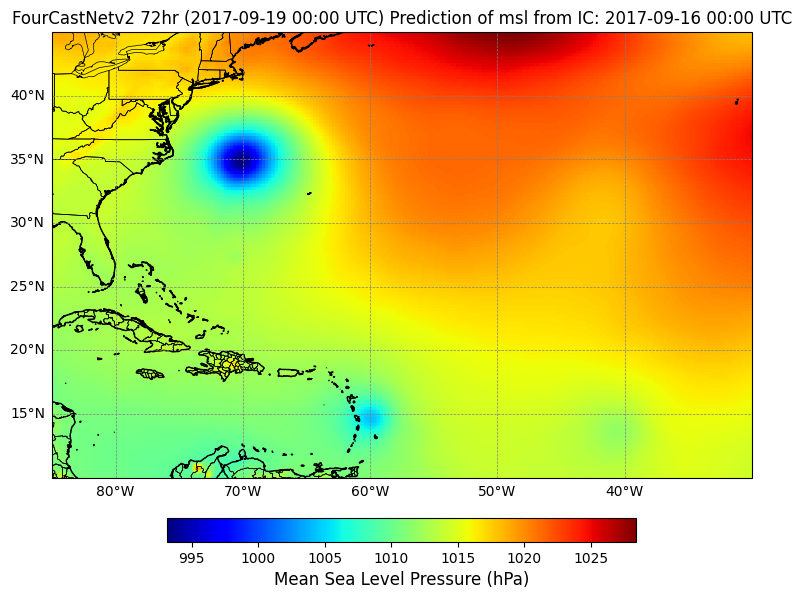

In [340]:
hurricane_prediction_plot(predictions=ds, variable='msl', t=0)
hurricane_prediction_plot(predictions=ds, variable='msl', t=4)
hurricane_prediction_plot(predictions=ds, variable='msl', t=8)
hurricane_prediction_plot(predictions=ds, variable='msl', t=12)




In [343]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os

def save_hurricane_prediction_frame(predictions, variable, t, out_dir, huh=False):
    dat = predictions[variable].values[t]
    if huh:
        dat = dat[0]
    if variable in ['sp', 'msl']:
        dat = dat / 100

    projection = ccrs.PlateCarree()

    
    #ADJUST EXTENT
    #KATRINA 2005
    extent = [-98, -70, 21, 44]
    #ERIN 2025
    extent = [-85, -60, 17, 41]
    #HARVEY 2017
    extent = [-105,-70,17,40]
    #PATRICIA 2015
    extent = [-120,-95,10,30]
    #MARIA 2017
    extent = [-85,-30,10,45]

    

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5)

    im = ax.imshow(dat, extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(),
                   cmap="jet", origin='upper')#,vmin=992,vmax=1020)

    import numpy as np
    import pandas as pd
    
    # Grab times from the dataset
    ic_dt = pd.to_datetime(ds.time.values)                      # scalar IC time (UTC)
    lead_hours = int(ds.step.values[t] / np.timedelta64(1, 'h'))  # lead in hours for frame t
    valid_dt = pd.to_datetime(ds.valid_time.values[t])          # valid time for frame t (UTC)
    
    # Nice strings
    ic_str = ic_dt.strftime("%Y-%m-%d %H:%M UTC")
    valid_str = valid_dt.strftime("%Y-%m-%d %H:%M UTC")
    
    ax.set_title(
        f"FourCastNetv2 {lead_hours}hr ({valid_str}) Prediction of {variable} "
        f"from IC: {ic_str}",
        fontsize=12
    )
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
    cbar.set_label(f"{variable_info[variable]['name']} ({variable_info[variable]['unit']})", fontsize=12)

    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
    gl.top_labels = False
    gl.right_labels = False

    os.makedirs(out_dir, exist_ok=True)
    frame_path = os.path.join(out_dir, f"{variable}_t{t:02d}.png")
    plt.savefig(frame_path, dpi=150)
    plt.close()

from PIL import Image

def make_gif_from_frames(output_dir, variable, num_frames, gif_name="maria_prediction.gif"):
    frames = []
    for t in range(num_frames):
        frame_file = os.path.join(output_dir, f"{variable}_t{t:02d}.png")
        if os.path.exists(frame_file):
            frames.append(Image.open(frame_file))
        else:
            print(f"Warning: Missing frame {frame_file}")

    if frames:
        gif_path = os.path.join(output_dir, gif_name)
        frames[0].save(
            gif_path,
            save_all=True,
            append_images=frames[1:],
            duration=300,
            loop=0
        )
        print(f"✅ Saved GIF to {gif_path}")
    else:
        print("❌ No frames found. GIF not created.")


In [344]:
# Set up
output_dir = "/home/jovyan/maria_gif_frames"
variable = "msl"
timesteps = 40  # or however many you want <41

# Save PNGs
for t in range(timesteps):
    save_hurricane_prediction_frame(ds, variable, t, output_dir)

# Create GIF
make_gif_from_frames(output_dir, variable, timesteps)


✅ Saved GIF to /home/jovyan/maria_gif_frames/maria_prediction.gif
